In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot12DimsNS_T256_H05_tl_110data_StbleTgt  import get_config

In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [3]:
def rmse_ignore_nans(y_true, y_pred):
    return np.nanmean((y_true-y_pred)**2)

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()


In [4]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


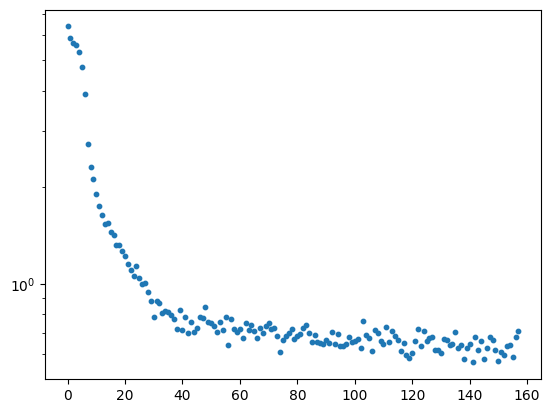

157

In [5]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

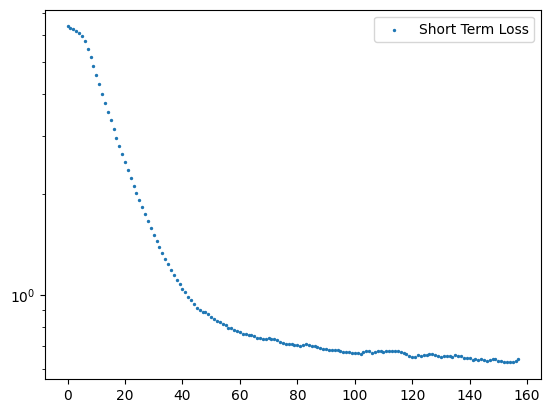

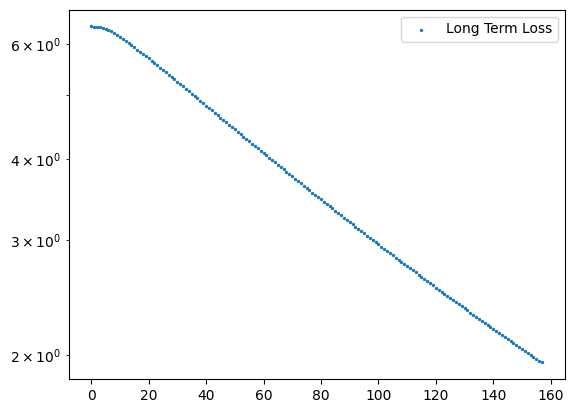

In [6]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

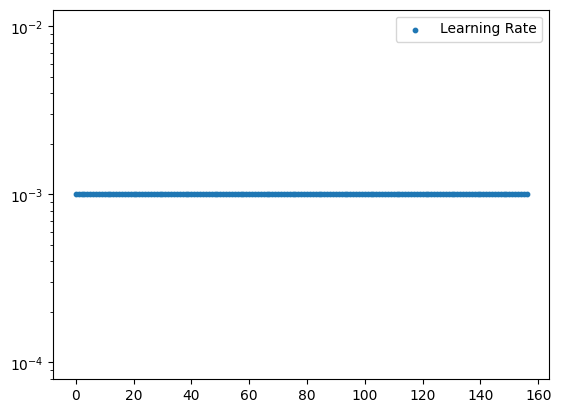

0.001


In [7]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(LRs[-1])

In [8]:
def get_drift_files(config, ts_type):
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/12DDimsNS/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "_MLP_" in file and ts_type in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_score_dir+file)
            elif "DriftTrack" in file and "global" in file:
                driftoostrack_local_files.append(root_score_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [9]:
ts_type = f"ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDimsNS".replace(".", "")
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config=config, ts_type=ts_type)
len(Nepochs_track)
print(drift_true_files)

['/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_fBiPot_12DDimsNS_OOSDriftTrack_1Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_fBiPot_12DDimsNS_OOSDriftTrack_2Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_fBiPot_12DDimsNS_OOSDriftTrack_4Nep_00t0_3906e-03dT_025a_-20b_00c_10ResLay_2LFac_BetaMax20e+01_true_states.npy', '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/TSPM_Markovian/12DDimsNS/TSPM_MLP_ST_0010FTh_fBiPot_1

In [10]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        print(str(Nepoch), str(Nepoch)[-1])
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError) as e:
        #del all_true_states, all_local_states, all_local_errors, total_local_errors
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

1 1
2 2
4 4
6 6
8 8
10 0
12 2
14 4


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_24232/2041196041.py:12: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_24232/2041196041.py:13: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


16 6
18 8
20 0
22 2
24 4
26 6
28 8
30 0
32 2
34 4
36 6
38 8
40 0
42 2
44 4
46 6
48 8
50 0
52 2
54 4
56 6
58 8
60 0
62 2
64 4
66 6
68 8
70 0
72 2
74 4
76 6
78 8
80 0
82 2
84 4
86 6
88 8
90 0
92 2
94 4
96 6
98 8
100 0
102 2
104 4
106 6
108 8
110 0
112 2
114 4
116 6
118 8
120 0
122 2
124 4
126 6
128 8
130 0
132 2
134 4
136 6
138 8
140 0
142 2
144 4
146 6
148 8
150 0
152 2
154 4


{1: 15.693589261155331,
 2: 18.18561021076954,
 4: 18.30202846573415,
 6: 15.84352411119305,
 8: 16.57769390286667,
 10: 16.693800524635773,
 12: 17.864198102098367,
 14: 22.801577858450734,
 16: 31.811351159411238,
 18: 54.35398352720246,
 20: 70.200179078021,
 22: 50.89378360372233,
 24: 58.34786551791591,
 26: 63.934909292377384,
 28: 42.68530352791281,
 30: 30.834047079892958,
 32: 24.53540679399128,
 34: 22.626203892373887,
 36: 21.799238732425852,
 38: 22.101841723398284,
 40: 21.393418989758203,
 42: 21.41913314930725,
 44: 21.618132928318083,
 46: 23.123555616382394,
 48: 22.146748463199746,
 50: 22.014993331696033,
 52: 21.609833067591726,
 54: 21.76452408602523,
 56: 23.228134510712522,
 58: 23.351171469321745,
 60: 22.21197810983919,
 62: 22.91773236061642,
 64: 22.830866514043667,
 66: 23.275005063196517,
 68: 22.10510760823326,
 70: 22.197195029035388,
 72: 22.870982932128676,
 74: 21.110121515280827,
 76: 21.802404666119923,
 78: 22.4203520049707,
 80: 23.34014352467851,


In [11]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])
print(Nepochs_losses)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157]


In [12]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
print(Nepochs_losses)
common_epochs = np.intersect1d(common_epochs, np.arange(40, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
print(common_epochs)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157]
[ 40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74
  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110
 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146
 148 150 152 154]


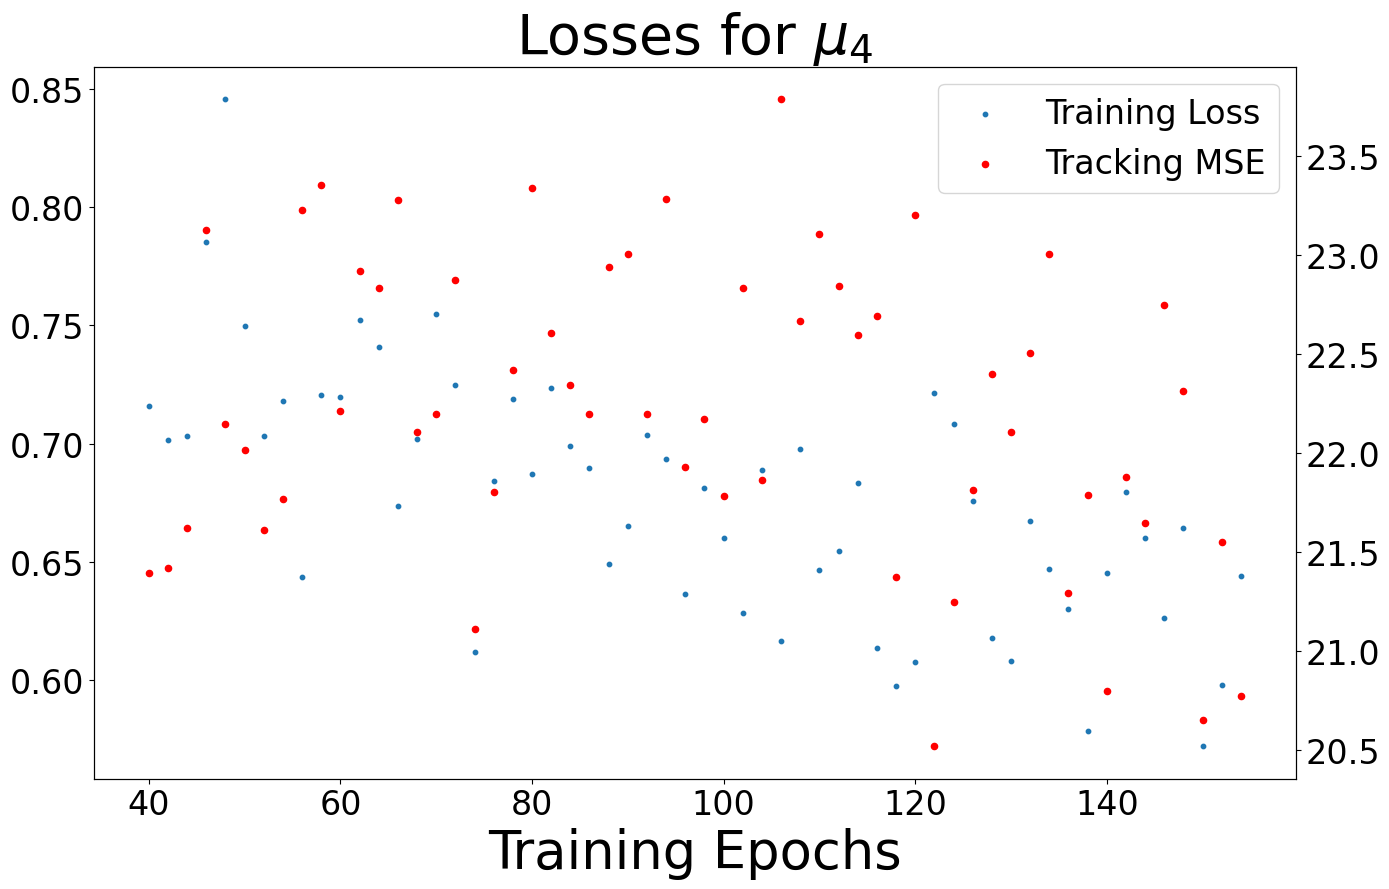

In [13]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for $\mu_{4}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/12DDimsNS/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDimsNS_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

(2, 100, 257, 12)


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_24232/2436981284.py:17: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_24232/2436981284.py:18: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


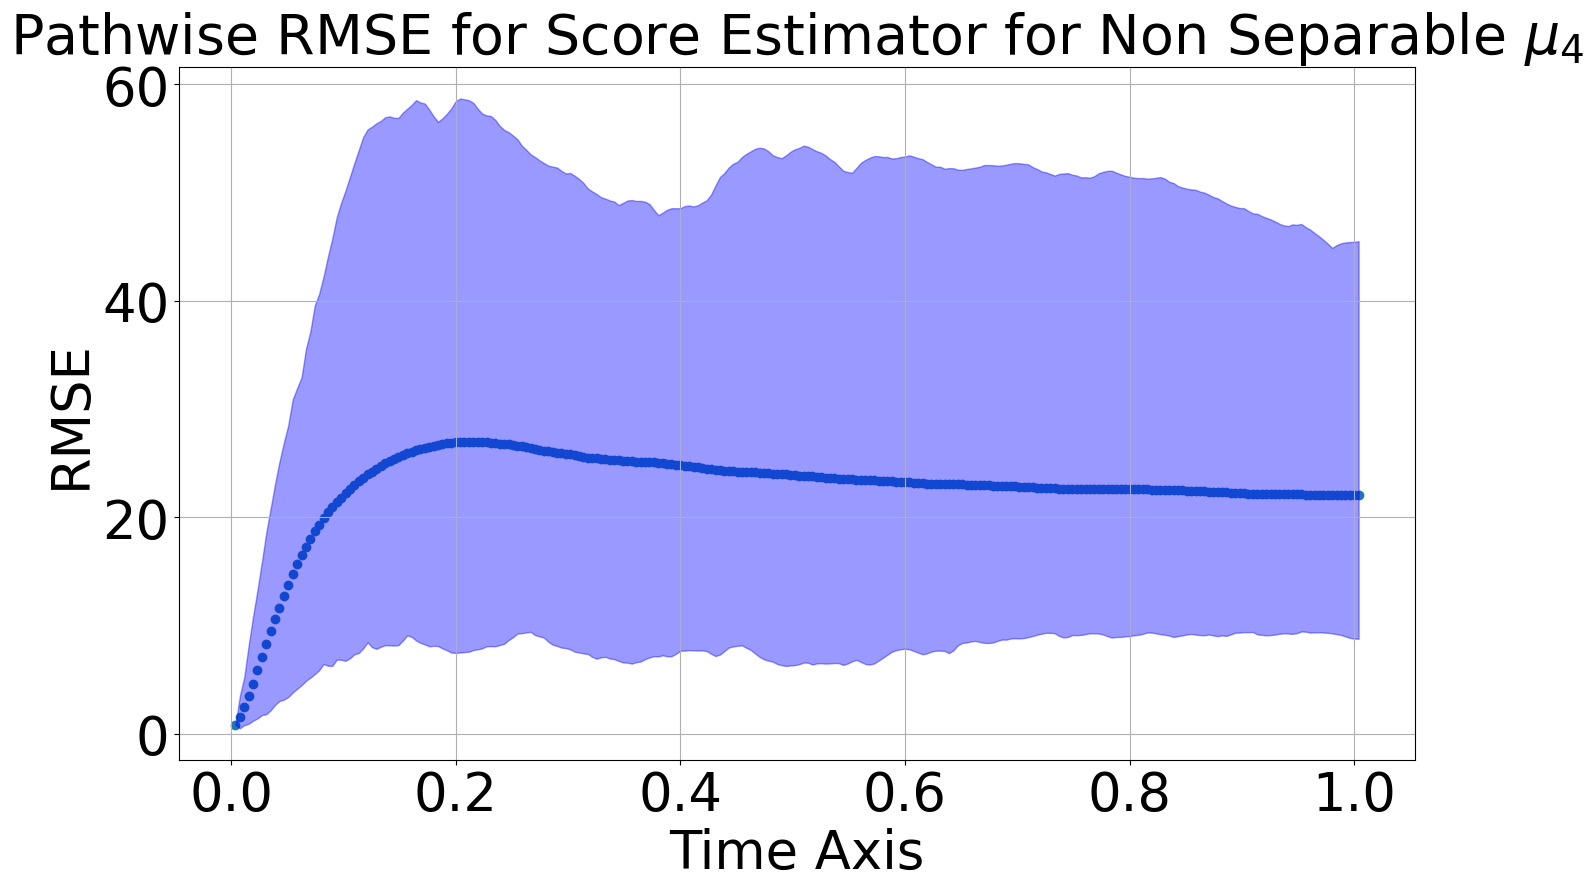

Final time cumulative MSE local-time error 22.014993331696033 with final IQR (8.76562479092556, 45.49937140512398) at Nepoch 50

(2, 100, 257, 12)


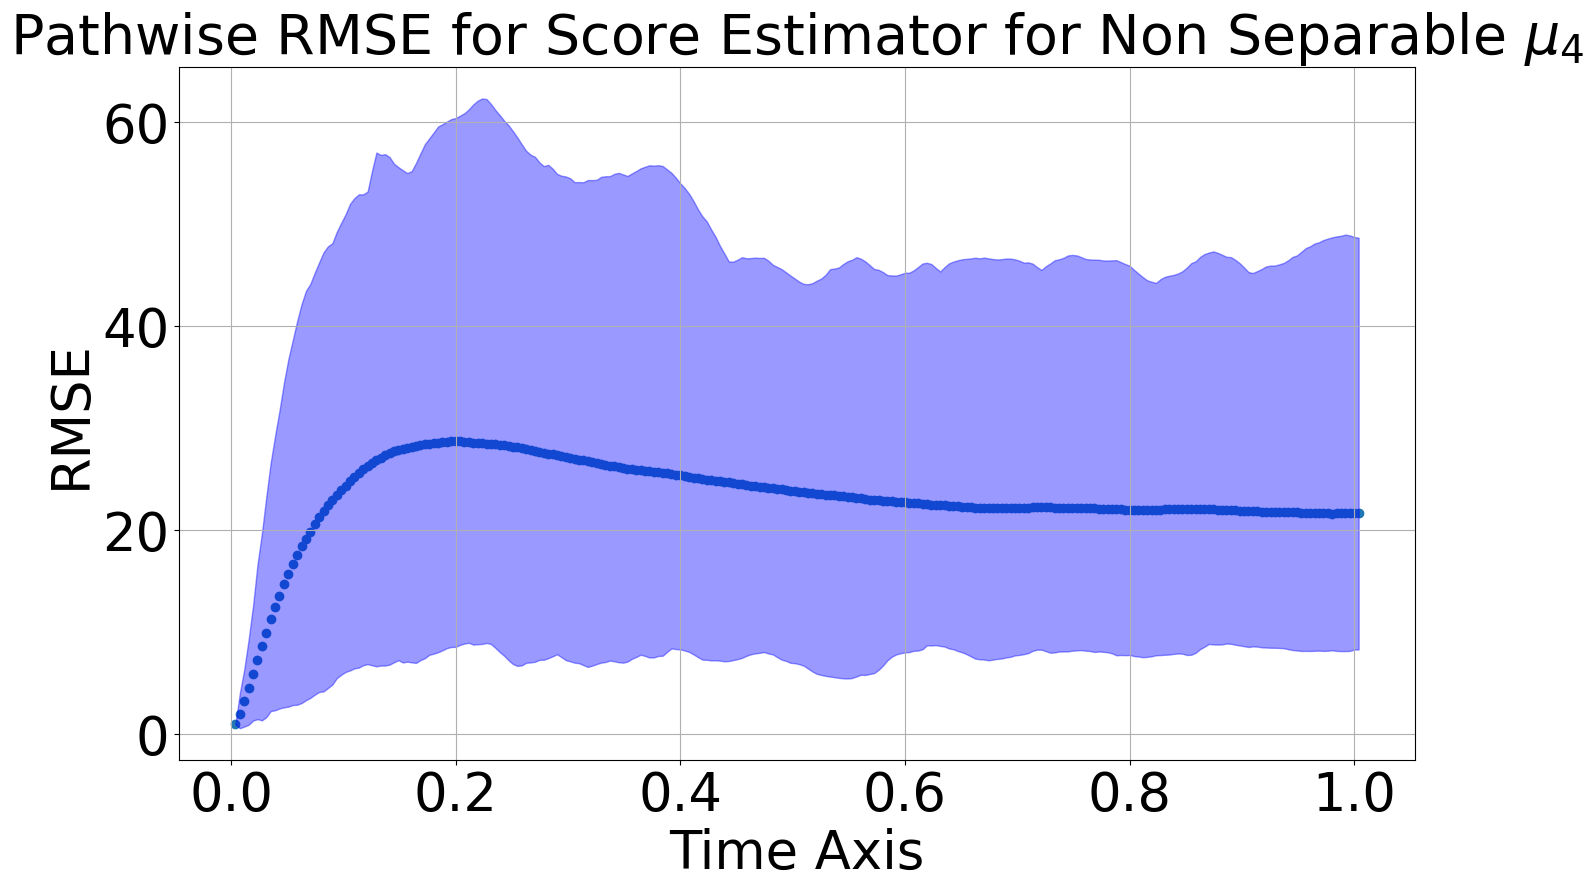

Final time cumulative MSE local-time error 21.609833067591726 with final IQR (8.272189415031992, 48.62521630173016) at Nepoch 52

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)


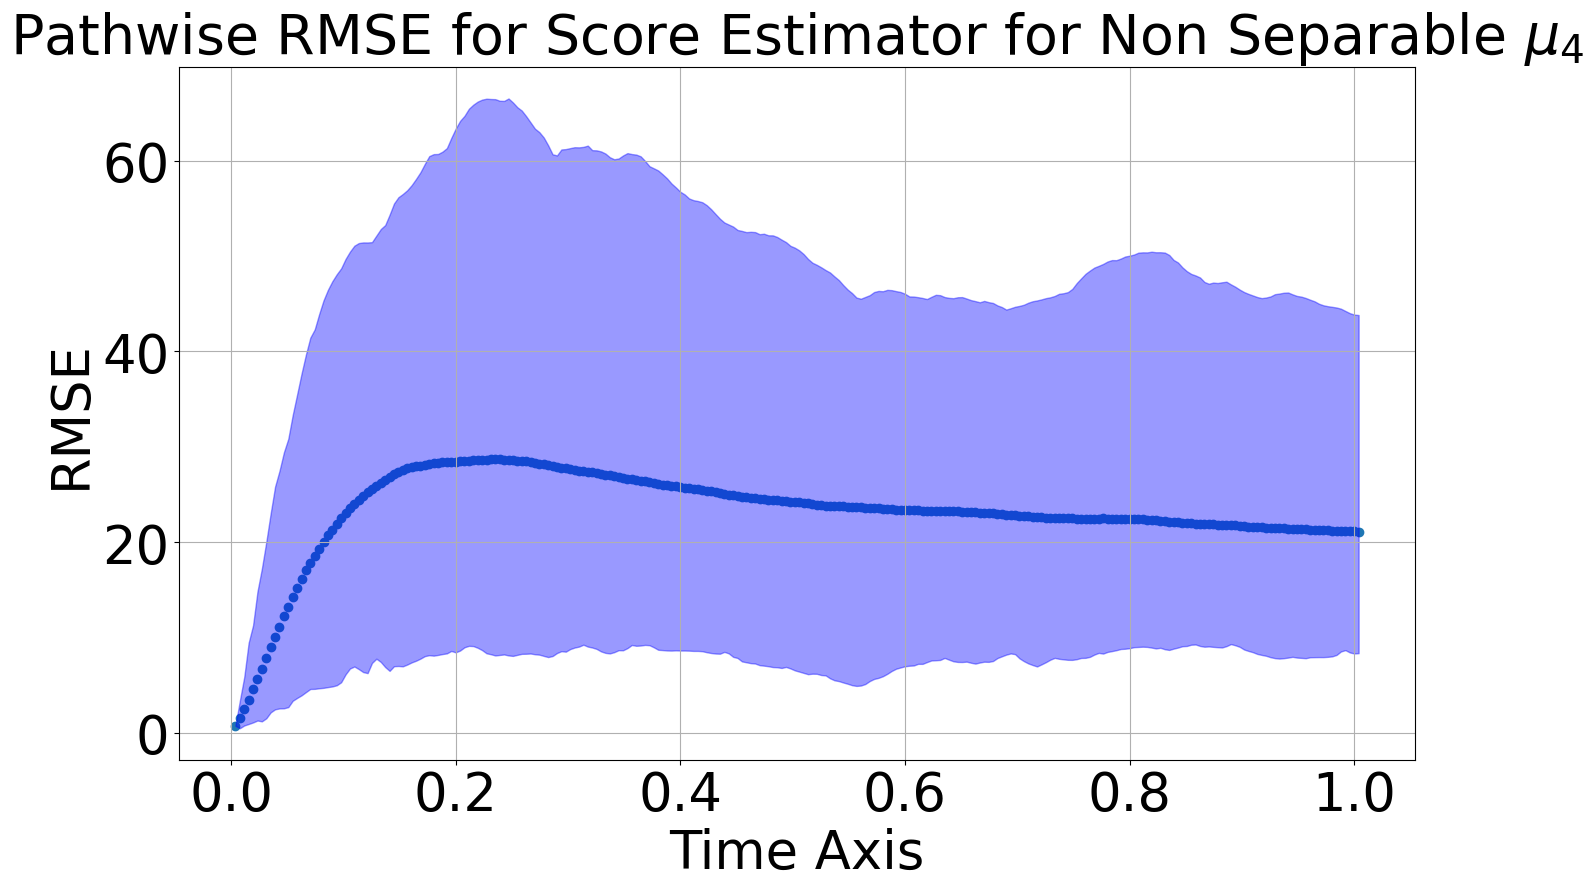

Final time cumulative MSE local-time error 21.110121515280827 with final IQR (8.362473430897953, 43.81136360291444) at Nepoch 74

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)


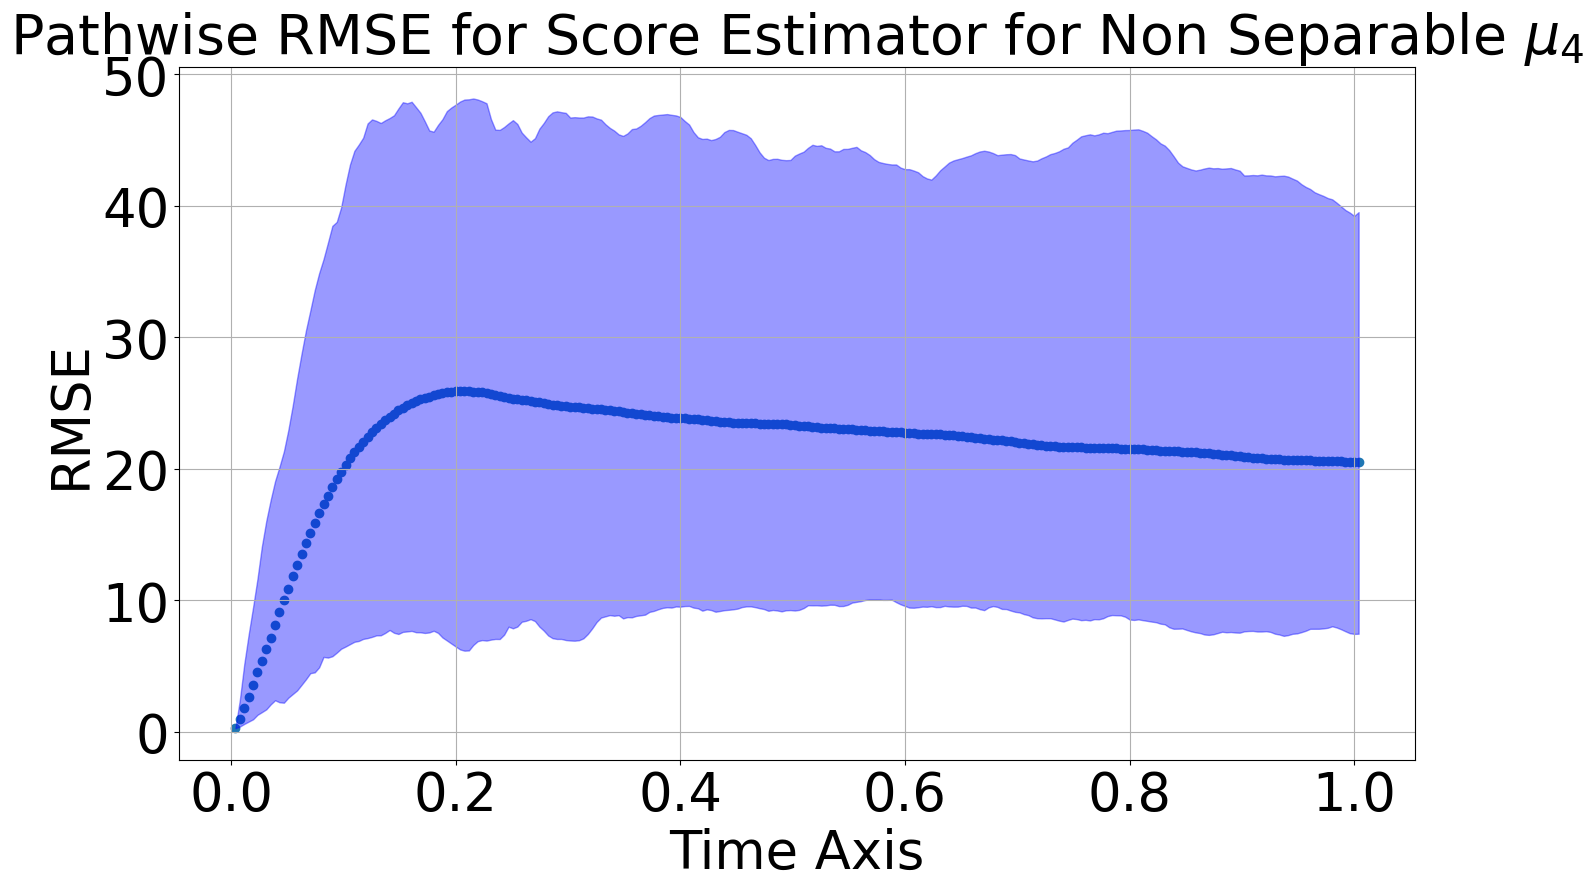

Final time cumulative MSE local-time error 20.516954756731238 with final IQR (7.4670753621792, 39.53197197371872) at Nepoch 122

(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)
(2, 100, 257, 12)


In [14]:
curr_rmse = np.inf
toSave = False
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        if Nepoch < 50: raise FileNotFoundError
        num_diff_times = 1
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        print(all_local_states.shape)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Score Estimator for Non Separable $\mu_4$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/TSPM_Markovian/12DDimsNS/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_fBiPot_{config.ndims}DDimsNS_DriftTrack_{Nepoch}Nep_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue